In [150]:
import numpy as np
import seaborn as sns
from tqdm import tqdm

# Parameters

In [151]:
initial_cases = 1000
imported_cases_per_step = 2

discount = 0.9
num_population = 100000

# Cost of setting R
R_0 = 2.5
power = 1.0
scale_factor = 1e10

# Cost of N (number of cases)
hospital_capacity = 20000
cost_per_hospital_visit = 50000
cost_per_hospital_deprived_case = 500000

In [152]:
def cost_of_r(r, power=power, scale_factor=scale_factor):
    baseline = 1/(R_0 ** power)
    if r >= R_0:
        return 0
    else:
        return (1/(r**power) - baseline) * scale_factor

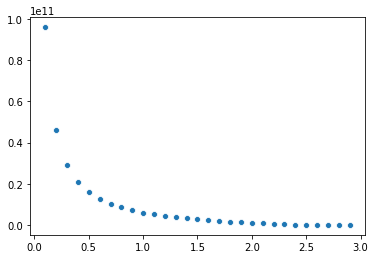

In [153]:
rs = np.arange(0.1, 3.0, 0.1)
costs_of_r = [cost_of_r(r) for r in rs]
sns.scatterplot(x=rs, y=costs_of_r)

In [154]:
def cost_of_n(n, slope1=cost_per_hospital_visit, slope2=cost_per_hospital_deprived_case, capacity=hospital_capacity):
    if n <= 0:
        return 0
    elif n <= capacity:
        return n * slope1
    else:
        return capacity * slope1 + (n - capacity) * slope2

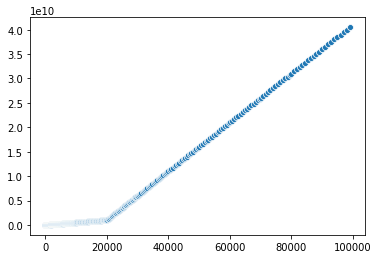

In [155]:
ns = sum([list(range(100*i, 100*(i+1), i+1)) for i in range(10)], []) + \
     sum([list(range(1000*i, 1000*(i+1), (i+1)*10)) for i in range(1, 10)], []) + \
     sum([list(range(10000*i, 10000*(i+1), (i+1)*100)) for i in range(1, 10)], [])
costs_of_n = [cost_of_n(n) for n in ns]
sns.scatterplot(x=ns, y=costs_of_n)

In [156]:
np.random.default_rng().poisson(lam=100)

105

In [157]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [158]:
def step(state, action):
    # state: number of current cases (discretized)
    # action: value of R_effective to set (discretized)
    # return: new_state, reward
    
    r_effective = action
    current_cases = state
    
    fraction_susceptible = (num_population - current_cases) / num_population
    expected_new_cases = (current_cases * r_effective + imported_cases_per_step) * fraction_susceptible

    # TODO: change to negative binomial; look up constant in literature for COVID
    new_state = np.random.default_rng().poisson(lam=expected_new_cases)
    reward = -cost_of_n(new_state) - cost_of_r(r_effective)
    
    new_state = find_nearest(ns, new_state)  # discretized case count
    
    return new_state, reward

In [159]:
step(10000, 2.5)

(22400, -2166000000)

In [160]:
step(10000, 2.0)

(18000, -1902249999.9999998)

In [161]:
step(10000, 1.0)

(8990, -6448500000.0)

## Initial Conditions

## Value Iteration

In [162]:
value_table = {n: 0 for n in ns}
# current_state = initial_cases

for i in tqdm(range(20)):
    new_value_table = {}
    for state in value_table:
        rewards = {}
        for action in rs:
            new_state, reward = step(state, action)
            future_reward = value_table[new_state]
            value = reward + discount * future_reward
            rewards[action] = value
        argmax_reward, max_reward = max(rewards.items(), key=lambda x: x[1])
        new_value_table[state] = max_reward
    value_table = new_value_table

100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


In [169]:
'%E' % min(value_table.items(), key=lambda x: x[1])[1]

'-4.902375E+10'

In [167]:
'%E' % value_table[ns[-1]]

'-2.960253E+10'

In [170]:
'%E' % value_table[ns[0]]

'-4.339226E+09'